In [2]:
def parse_pidstat(data: str):
    rows = data.split("\n")
    parsed_rows = []
    for row in rows[1:]:
        row = row.strip()
        if len(row) == 0:
            continue
        if "UID" in row:
            continue
        parsed = row.split(" ")
        parsed = list(filter(lambda x: len(x) > 0, parsed))

        datum = {
            'timestamp': int(parsed[0]),
            'pid': int(parsed[2]),
            'cpu':float(parsed[7]),
            'command': parsed[-1]
        }

        parsed_rows.append(datum)
    
    processes = set()
    for row in parsed_rows:
        processes.add(row['command'])

    aggregation = {}
    for row in parsed_rows:
        if row['timestamp'] not in aggregation:
            aggregation[row['timestamp']] = {
                'timestamp': row['timestamp'],
                'cpu': {}
            }
            for proccess in processes:
                aggregation[row['timestamp']]['cpu'][proccess] = 0
        aggregation[row['timestamp']]['cpu'][row['command']] += row['cpu']

    output_data = []
    for timestamp in sorted(aggregation.keys()):
        output_data.append(aggregation[timestamp])

    return output_data

In [3]:
import json
from dateutil.parser import isoparse

def parse_iostat(dataStr:str):
    data= json.loads(dataStr)
    data = data['statistics']
    output_data = []
    for datum in data:
        disk = None
        for disk in datum['disk']:
            if disk['disk_device'] != 'nvme0n1':
                continue
        assert disk is not None
        t = {
            'timestamp': int(isoparse(datum['timestamp']).timestamp()),
            'disk': float(disk['kB_wrtn/s'])
        }
        output_data.append(t)
    return output_data        

In [4]:
def read_report(report_id, stat_kind='pidstat'):
    with open(f'reports/{report_id}/fileio/report-{stat_kind}.log', 'r', encoding='utf-8') as f:
        data = f.read()

    if stat_kind=='pidstat':
        return parse_pidstat(data)
    
    if stat_kind=='iostat':
        return parse_iostat(data)
    
    raise Exception("Unknown stat kind "+stat_kind)

In [5]:
import os

reports = os.listdir("reports")
reports = sorted(reports)
for i in range(len(reports)):
    print(f'[{i}] {reports[i]}')

[0] 1698723913
[1] 1698724146-pure
[2] 1698731219-vaccine
[3] 1698739184
[4] 1698740961-pms


In [6]:
def pidstat(datum):
    cpus = datum['cpu']
    value = {
        'stress': 0,
        'agent': 0,
        'others': 0
    }
    for cpu in cpus:
        if 'stress' in cpu:
            value['stress'] += cpus[cpu]
        elif 'agent' in cpu:
            value['agent'] += cpus[cpu]
        else:
            value['others'] += cpus[cpu]
    return value

def iostat(datum):
    return datum['disk']

In [7]:
def graphfy(data, value_function):
    x = []
    y = []
    for datum in data:
        x.append(datum['timestamp'])
        y.append(value_function(datum))
    return x, y

In [9]:
graph_dict = {}

report_names = [
    reports[1],
    reports[2],
    reports[4]
]

stat_kinds = [
    'pidstat',
    'iostat'
]

value_functions = {
    'pidstat': pidstat,
    'iostat': iostat
}

for report_name in report_names:
    graph_dict[report_name] = {}
    for stat_kind in stat_kinds:
        report = read_report(report_name, stat_kind)
        graph_dict[report_name][stat_kind] = graphfy(report, value_functions[stat_kind])

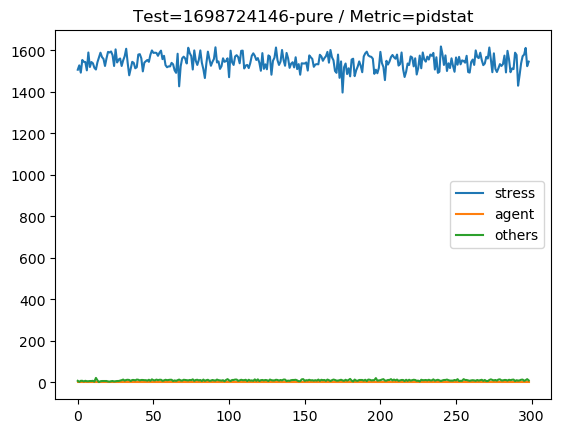

No handles with labels found to put in legend.


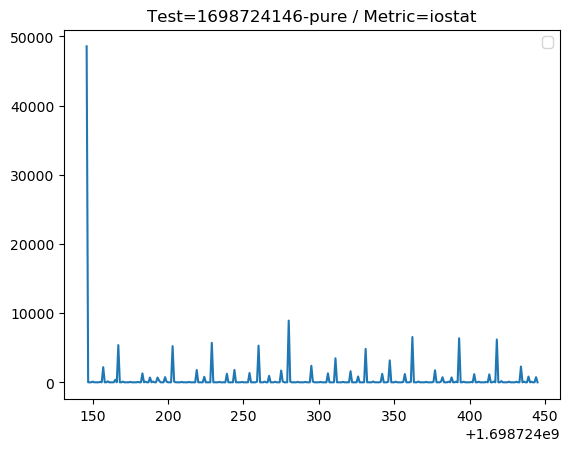

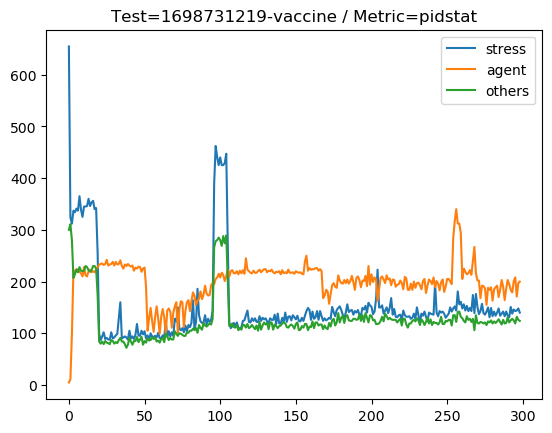

No handles with labels found to put in legend.


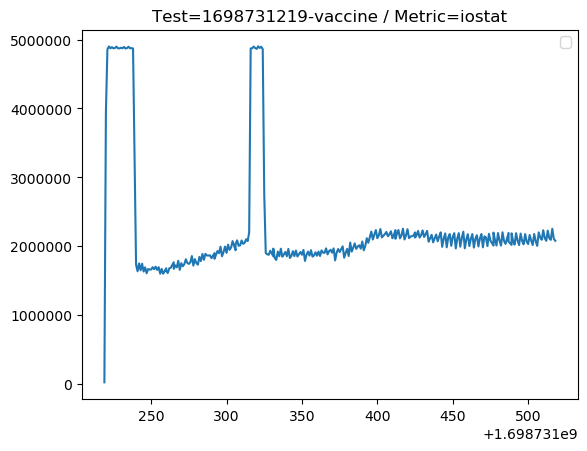

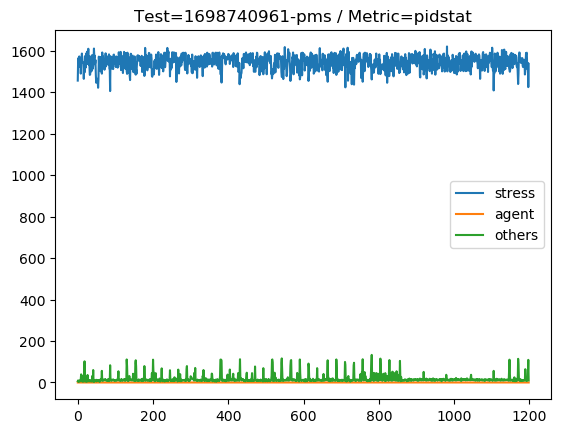

No handles with labels found to put in legend.


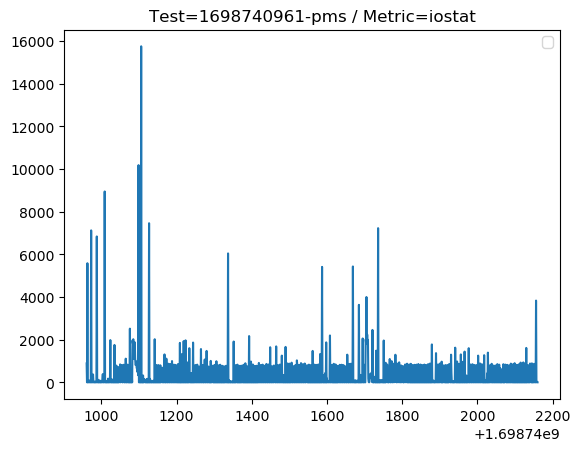

In [12]:
from matplotlib import pyplot as plt
import os

os.mkdir('figures')

for report_name in report_names:
    for stat_kind in stat_kinds:
        x, y = graph_dict[report_name][stat_kind]
        if isinstance(y[0],dict):
            for key in y[0]:
                y_value = list(map(lambda y:y[key], y))
                plt.plot(y_value, label=key)
        else:
            plt.plot(x,y)
        plt.title(f'Test={report_name} / Metric={stat_kind}')
        plt.legend()
        plt.savefig(f'figures/{report_name}-{stat_kind}.png')
        plt.show()
